In [ ]:
pip install pandas numpy datasets tensorflow scikit-learn fastapi uvicorn matplotlib

In [2]:
!pip install datasets

Epoch 1/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0191 - val_loss: 0.0040
Epoch 2/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 3/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 4/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 6/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 9/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 11/50
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 12/50
3642/3642 ━━━━━━━

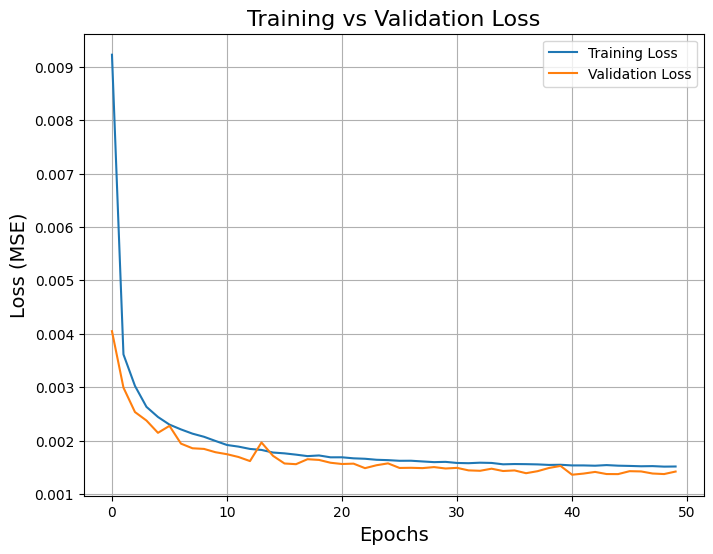

2024/2024 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Best Threshold based on F1-score: 0.008527 (F1 = 0.9570)
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


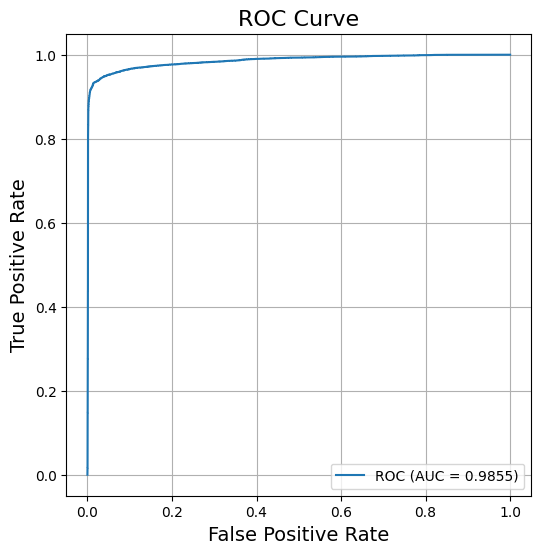

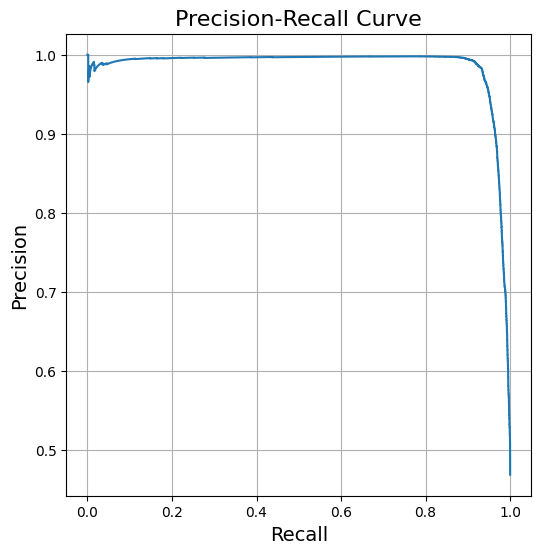

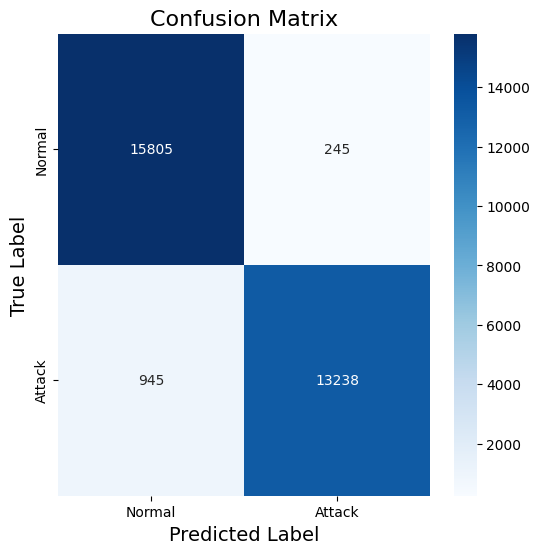

Accuracy: 0.9606
Precision: 0.9818
Recall: 0.9334
F1 Score: 0.9570
ROC AUC: 0.9855
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


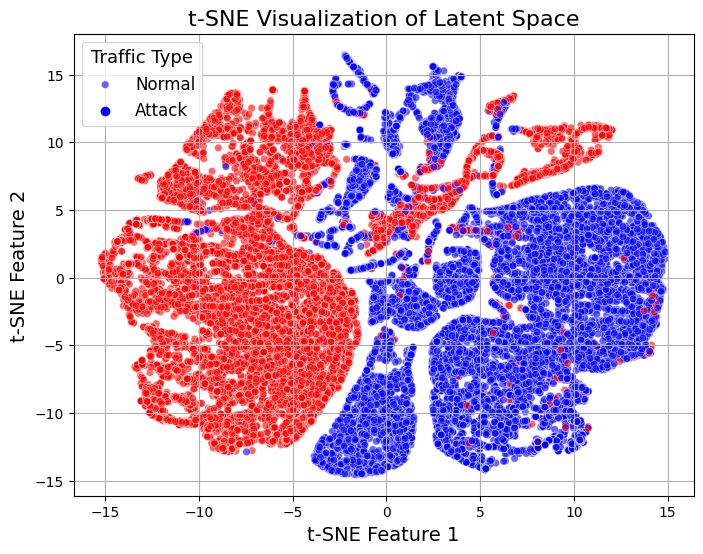

In [6]:
# =========================================
#  Import necessary libraries
# =========================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             roc_curve, precision_recall_curve)
from sklearn.manifold import TSNE

# =========================================
#  1️⃣ Load & Preprocess NSL-KDD Dataset
# =========================================

# Load dataset
ds = load_dataset("Mireu-Lab/NSL-KDD")
df = pd.DataFrame(ds["train"])

# Map 'class' to binary labels
df["class"] = df["class"].apply(lambda x: 0 if x == "normal" else 1)

# One-hot encoding categorical features
categorical_features = ['protocol_type', 'service', 'flag']
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[categorical_features]).toarray()
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Merge encoded features
df = pd.concat([df.drop(columns=categorical_features), encoded_df], axis=1)

# Extract features and labels
X = df.drop(columns=['class']).values
y = df['class'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select only normal traffic for training (Self-Supervised Learning)
X_train_normal = X_train[y_train == 0]

# =========================================
#  2️⃣ Define Improved Autoencoder with Attention
# =========================================

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        q, k, v = inputs, inputs, inputs
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_scores, v)
        return attention_output

# L2 regularization
reg = regularizers.l2(1e-5)

input_dim = X_train_normal.shape[1]

inputs = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu', kernel_regularizer=reg)(inputs)
encoded = Dense(64, activation='relu', kernel_regularizer=reg)(encoded)
encoded = AttentionLayer()(encoded)
encoded = Dense(32, activation='relu', kernel_regularizer=reg)(encoded)
encoded = Dropout(0.05)(encoded)
encoded = Dense(32, activation='relu', kernel_regularizer=reg)(encoded)  # Extra deeper layer

decoded = Dense(64, activation='relu', kernel_regularizer=reg)(encoded)
decoded = Dense(128, activation='relu', kernel_regularizer=reg)(decoded)
outputs = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # 👈 Adam + MSE

# =========================================
#  3️⃣ Train Autoencoder and Save History
# =========================================

history = autoencoder.fit(
    X_train_normal, 
    X_train_normal, 
    epochs=50, 
    batch_size=16, 
    validation_split=0.1,
    verbose=1
)

# Plot Training and Validation Loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.title('Training vs Validation Loss', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# =========================================
#  4️⃣ Compute Reconstruction Loss and Dynamic Threshold
# =========================================

reconstruction = autoencoder.predict(X_train_normal)
train_loss = np.mean(np.square(X_train_normal - reconstruction), axis=1)  # MSE

# Find optimal threshold dynamically
best_f1 = 0
best_threshold = 0
val_reconstruction = autoencoder.predict(X_test)
val_loss = np.mean(np.square(X_test - val_reconstruction), axis=1)  # MSE

threshold_range = np.linspace(np.percentile(train_loss, 85), np.percentile(train_loss, 99), 50)

for thresh in threshold_range:
    y_pred_thresh = (val_loss > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Best Threshold based on F1-score: {best_threshold:.6f} (F1 = {best_f1:.4f})")

# =========================================
#  5️⃣ Evaluate Final Model
# =========================================

def evaluate_model(autoencoder, X_test, y_test, threshold):
    reconstructions = autoencoder.predict(X_test)
    test_loss = np.mean(np.square(X_test - reconstructions), axis=1)  # MSE
    y_pred = (test_loss > threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, test_loss)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, test_loss)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label="ROC (AUC = {:.4f})".format(roc_auc))
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.title("ROC Curve", fontsize=16)
    plt.show()

    # Precision-Recall Curve
    precision, recall_pr, _ = precision_recall_curve(y_test, test_loss)
    plt.figure(figsize=(6,6))
    plt.plot(recall_pr, precision, label="PR Curve")
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.grid(True)
    plt.title("Precision-Recall Curve", fontsize=16)
    plt.show()

    # Confusion Matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

evaluate_model(autoencoder, X_test, y_test, best_threshold)

# =========================================
#  6️⃣ t-SNE Visualization (Fixed Colors: Blue-Normal, Red-Attack)
# =========================================

# Encoder Model
encoder_model = Model(inputs, encoded)
latent_features = encoder_model.predict(X_test)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_features = tsne.fit_transform(latent_features)

# Correct Color Mapping
plt.figure(figsize=(8,6))
palette = {0: "blue", 1: "red"}
sns.scatterplot(
    x=tsne_features[:,0], 
    y=tsne_features[:,1], 
    hue=y_test, 
    palette=palette,
    alpha=0.6,
    s=30
)
plt.title("t-SNE Visualization of Latent Space", fontsize=16)
plt.xlabel("t-SNE Feature 1", fontsize=14)
plt.ylabel("t-SNE Feature 2", fontsize=14)
plt.legend(title="Traffic Type", labels=["Normal", "Attack"], fontsize=12, title_fontsize=13)
plt.grid(True)
plt.show()
